In [1]:
from collections import defaultdict
import unicodedata as ud
import pandas as pd
import numpy as np
import math
import ast
import re

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

# 1. Dữ liệu thu thập

In [3]:
sentences = open('dataset/sentences.txt', encoding='utf-8').readlines()
tokenize_sentences = [sentence.split(' ') for sentence in sentences]

In [4]:
print('Số lượng câu đã thu thập:', len(sentences))
sentences[0:2]

Số lượng câu đã thu thập: 60


['Pha lập công trên đã giúp Rashford giải hạn bàn thắng tại sân Old Trafford kéo dài 845 phút .\n',
 'Với 3 điểm có được trong trận đấu này , Quỷ đỏ đã leo lên vị trí thứ 2 trên bảng xếp hạng Premier League với 30 điểm , chỉ kém đội đầu bảng Liverpool 2 điểm .\n']

In [5]:
max_str = max(tokenize_sentences, key=len)
print('Câu có số từ nhiều nhât:', len(max_str))
' '.join(max_str)

Câu có số từ nhiều nhât: 46


'Những thực phẩm được chế biến như hun khói , thức ăn ngâm tẩm , muối , món ăn chứa lượng muối cao thường có tỷ lệ mắc ung thư dạ dày cao hơn những người có thói quen ăn uống nhạt và thanh đạm .\n'

In [6]:
min_str = min(tokenize_sentences, key=len)
print('Câu có số từ ít nhât:', len(min_str))
' '.join(min_str)

Câu có số từ ít nhât: 8


'Nhiều người có hoàn cảnh giống ông .\n'

# 2. Tách từ

## Sử dụng thuật toán Longest Matching

In [7]:
def syllablize(sentence):
    word = '\w+'
    non_word = '[^\w\s]'
    digits = '\d+([\.,_]\d+)+'
    
    patterns = []
    patterns.extend([word, non_word, digits])
    patterns = f"({'|'.join(patterns)})"
    
    sentence = ud.normalize('NFC', sentence)
    tokens = re.findall(patterns, sentence, re.UNICODE)
    return [token[0] for token in tokens]

In [8]:
def load_n_grams(path):
    with open(path, encoding='utf8') as f:
        words = f.read()
        words = ast.literal_eval(words)
    return words

In [9]:
def longest_matching(sentence, bi_grams, tri_grams):
    syllables = syllablize(sentence)
    syl_len = len(syllables)
    
    curr_id = 0
    word_list = []
    done = False
    
    while (curr_id < syl_len) and (not done):
        curr_word = syllables[curr_id]
        if curr_id >= syl_len - 1:
            word_list.append(curr_word)
            done = True
        else:
            next_word = syllables[curr_id + 1]
            pair_word = ' '.join([curr_word.lower(), next_word.lower()])
            if curr_id >= (syl_len - 2):
                if pair_word in bi_grams:
                    word_list.append('_'.join([curr_word, next_word]))
                    curr_id += 2
                else:
                    word_list.append(curr_word)
                    curr_id += 1
            else:
                next_next_word = syllables[curr_id + 2]
                triple_word = ' '.join([pair_word, next_next_word.lower()])
                if triple_word in tri_grams:
                    word_list.append('_'.join([curr_word, next_word, next_next_word]))
                    curr_id += 3
                elif pair_word in bi_grams:
                    word_list.append('_'.join([curr_word, next_word]))
                    curr_id += 2
                else:
                    word_list.append(curr_word)
                    curr_id += 1
    return word_list

In [10]:
bi_grams = load_n_grams('resources/bi_grams.txt')
tri_grams = load_n_grams('resources/tri_grams.txt')
longest_matching('nhưng sự thực hiện vẫn còn chưa phù hợp', bi_grams, tri_grams)

['nhưng', 'sự_thực', 'hiện', 'vẫn', 'còn', 'chưa', 'phù_hợp']

In [11]:
with open('tokenize/longest_matching_tokens.txt', 'w', encoding='utf-8') as f:
    longest_matching_sentences = []
    for sentence in sentences:
        word_list = longest_matching(sentence, bi_grams, tri_grams)
        longest_matching_sentences.append(' '.join(word_list))
        for word in word_list: f.write(word + '\n')
        if sentence != sentences[-1]: f.write('\n')
longest_matching_sentences[0:3]

['Pha lập_công trên đã giúp Rashford giải hạn bàn thắng tại sân Old Trafford kéo dài 845 phút .',
 'Với 3 điểm có được trong trận đấu này , Quỷ đỏ đã leo lên vị_trí thứ 2 trên bảng xếp_hạng Premier League với 30 điểm , chỉ kém đội đầu_bảng Liverpool 2 điểm .',
 'Tổng_thống đắc_cử Joe Biden được cho đang cân_nhắc việc cắt bỏ chương_trình hiện_đại hóa hạt_nhân trị_giá 1 . 000 tỷ USD do chính_quyền Tổng_thống đương_nhiệm Donald Trump đề_xuất .']

In [12]:
count_longest_matching_compounds = 0
for sentence in longest_matching_sentences:
    for word in sentence.split():
        if '_' in word: count_longest_matching_compounds += 1
print('Số lượng từ ghép khi tách từ bằng thuật toán Longest Matching:', count_longest_matching_compounds)

Số lượng từ ghép khi tách từ bằng thuật toán Longest Matching: 257


## Sử dụng thư viện VnCoreNLP

In [13]:
from vncorenlp import VnCoreNLP
client = VnCoreNLP(address='http://127.0.0.1', port=9001)
word_list = client.tokenize('nhưng sự thực hiện vẫn còn chưa phù hợp')[0]
word_list

['nhưng', 'sự', 'thực_hiện', 'vẫn', 'còn', 'chưa', 'phù_hợp']

In [14]:
with open('tokenize/vncore_tokens.txt', 'w', encoding='utf-8') as f:
    vncore_sentences = []
    for sentence in sentences:
        word_list = client.tokenize(sentence)[0]
        vncore_sentences.append(' '.join(word_list))
        for word in word_list: f.write(word + '\n')
        if sentence != sentences[-1]: f.write('\n')
vncore_sentences[0:3]

['Pha lập_công trên đã giúp Rashford giải hạn bàn thắng tại sân Old_Trafford kéo_dài 845 phút .',
 'Với 3 điểm có được trong trận đấu này , Quỷ đỏ đã leo lên vị_trí thứ 2 trên bảng xếp_hạng Premier_League với 30 điểm , chỉ kém đội đầu_bảng Liverpool 2 điểm .',
 'Tổng_thống đắc_cử Joe_Biden được cho đang cân_nhắc việc cắt bỏ chương_trình hiện_đại_hoá hạt_nhân trị_giá 1.000 tỷ USD do chính_quyền Tổng_thống đương_nhiệm Donald_Trump đề_xuất .']

In [15]:
count_vncore_compounds = 0
for sentence in vncore_sentences:
    for word in sentence.split():
        if '_' in word: count_vncore_compounds += 1
print('Số lượng từ ghép khi tách từ bằng thư viện VnCoreNLP:', count_vncore_compounds)

Số lượng từ ghép khi tách từ bằng thư viện VnCoreNLP: 282


## Thủ công

In [16]:
with open('tokenize/manual_tokens.txt', 'r', encoding='utf-8') as f:
    manual_tokenize_sentences = []
    sentence = ''
    for word in f:
        if word == '\n': 
            manual_tokenize_sentences.append(sentence.strip())
            sentence = ''
        else: sentence += word.replace('\n', ' ')
manual_tokenize_sentences[0:3]

['Pha lập_công trên đã giúp Rashford giải_hạn bàn_thắng tại sân Old_Trafford kéo_dài 845 phút .',
 'Với 3 điểm có được trong trận_đấu này , Quỷ_đỏ đã leo_lên vị_trí thứ 2 trên bảng xếp_hạng Premier_League với 30 điểm , chỉ kém đội đầu_bảng Liverpool 2 điểm .',
 'Tổng_thống đắc_cử Joe_Biden được cho đang cân_nhắc việc_cắt_bỏ chương_trình hiện_đại_hoá hạt_nhân trị_giá 1.000 tỷ USD do chính_quyền Tổng_thống đương_nhiệm Donald_Trump đề_xuất .']

In [17]:
count_manual_tokenize_compounds = 0
for sentence in manual_tokenize_sentences:
    for word in sentence.split():
        if '_' in word: count_manual_tokenize_compounds += 1
print('Số lượng từ ghép khi tách từ thủ công:', count_manual_tokenize_compounds)

Số lượng từ ghép khi tách từ thủ công: 303


## Đánh giá kết quả tách từ

In [18]:
def count_correct_words(pred, source, n_grams=3):
    pred_words = pred.split()
    source_words = source.split()
    
    total_true, tp = 0, 0
    total_errors, fp = 0, 0
    
    idx = 0
    while idx < len(pred_words):
        if pred_words[idx] not in source_words[idx:(idx + n_grams)]: 
            if '_' in pred_words[idx]: fp += 1
            del pred_words[idx]
            total_errors += 1
        else: idx += 1
    
    idx = 0
    while idx < len(source_words):
        if source_words[idx] not in pred_words[idx:(idx + n_grams)]: 
            del source_words[idx]
        else: idx += 1
    
    if len(pred_words) < len(source_words): words = pred_words
    else: words = source_words
    
    for idx in range (len(words)):
        if pred_words[idx] == source_words[idx]:
            if '_' in pred_words[idx]: tp += 1 
            total_true += 1
                    
    return total_true, total_errors, tp, fp

In [19]:
def tokenize_evaluation(pred, source, n_grams=3):
    total_true = 0
    total_errors = 0
    total_words = 0
    
    pred_tp = 0
    pred_fp = 0
    
    for pred_sentence, source_sentence in zip(pred, source):
        total_words += len(source_sentence.split())
        if pred_sentence != source_sentence:
            true, error, tp, fp = count_correct_words(pred_sentence, source_sentence, n_grams)
            total_true += true 
            total_errors += error
            pred_tp += tp
            pred_fp += fp
        else:
            for word in source_sentence.split():
                if '_' in word: pred_tp += 1
                total_true += 1
    return {
        'Accuracy': total_true / total_words, 
        'Precision': pred_tp / (pred_tp + pred_fp),
        'Recall': pred_tp / count_manual_tokenize_compounds,
        'True Positive': pred_tp, 
        'False Positive': pred_fp,
        'Total True': total_true, 
        'Total Errors': total_errors
    }

In [20]:
longest_matching_evaluation = tokenize_evaluation(longest_matching_sentences, manual_tokenize_sentences)
vncore_evaluation = tokenize_evaluation(vncore_sentences, manual_tokenize_sentences)
pd.DataFrame(
    [longest_matching_evaluation, vncore_evaluation], 
    index = ['Longest Matching', 'VnCoreNLP']
).astype(object).T

,Longest Matching,VnCoreNLP
Accuracy,0.854606,0.931188
Precision,0.888446,0.949275
Recall,0.735974,0.864686
True Positive,223,262
False Positive,28,14
Total True,770,839
Total Errors,210,99


# 3. Tạo ngữ liệu

In [21]:
longest_matching_tokens = open('tokenize/longest_matching_tokens.txt', encoding='utf-8').readlines()
print('Số lượng từ:', len(longest_matching_tokens))
longest_matching_tokens[0:5]

Số lượng từ: 1049


['Pha\n', 'lập_công\n', 'trên\n', 'đã\n', 'giúp\n']

In [22]:
vncore_tokens = open('tokenize/vncore_tokens.txt', encoding='utf-8').readlines()
print('Số lượng từ:', len(vncore_tokens))
vncore_tokens[0:5]

Số lượng từ: 1006


['Pha\n', 'lập_công\n', 'trên\n', 'đã\n', 'giúp\n']

In [23]:
manual_tokens = open('tokenize/manual_tokens.txt', encoding='utf-8').readlines()
print('Số lượng từ:', len(manual_tokens))
manual_tokens[0:5]

Số lượng từ: 969


['Pha\n', 'lập_công\n', 'trên\n', 'đã\n', 'giúp\n']

## Tạo dataset bán thủ công: Gán nhãn trước bằng VnCoreNLP sau đó kiểm tra lại nhãn

In [24]:
with open('dataset/gold.txt', 'w', encoding='utf-8') as f:
    for word in manual_tokens:
        word = word.replace('\n', '')
        
        if '_' not in word: tag = client.pos_tag(word)
        else: tag = client.pos_tag(word.replace('_', ' '))
        
        if tag == []: f.write('\n')
        else: f.write(f'{word}\t{tag[0][0][1]}\n')

## Chia ngữ liệu vừa tạo thành các bộ Train và Test

**Chú ý: Trước khi thực hiện bước này phải check lại nhãn đã được gán bán thủ công ở bước trên trước**

In [25]:
gold_corpus = open('dataset/gold.txt', encoding='utf-8').readlines()
new_line_idx = [i for i, item in enumerate(manual_tokens) if item == '\n']

In [26]:
with open('dataset/train_gold.txt', 'w', encoding='utf-8') as f:
    for line in gold_corpus[:new_line_idx[49]]: f.write(line)
        
with open('dataset/test_gold.txt', 'w', encoding='utf-8') as f:
    for line in gold_corpus[new_line_idx[49] + 1:]: f.write(line)

In [27]:
with open('dataset/train_words.txt', 'w', encoding='utf-8') as f:
    for line in gold_corpus[:new_line_idx[49]]: 
        f.write(re.sub('\t.*', '', line))
        
with open('dataset/test_words.txt', 'w', encoding='utf-8') as f:
    for line in gold_corpus[new_line_idx[49] + 1:]: 
        f.write(re.sub('\t.*', '', line))

# 4. Đọc dữ liệu

In [28]:
def preprocess(vocabs_dict, path):
    data = []
    file = open(path, encoding='utf-8').readlines()
    
    for index, word in enumerate(file):
        if not word.split():
            word = '--n--'
            data.append(word)
            continue
        elif word.strip() not in vocabs_dict:
            word = '--unk--'
            data.append(word)
            continue
        data.append(word.strip())
    return data

In [29]:
def plot_tag_counts(gold):
    tags = [word_tag.split()[1] for word_tag in gold if word_tag.split()]
    tag_counts = pd.DataFrame(tags)[0].value_counts()
    tag_counts.plot.bar(rot=0, width=0.7, legend=False, figsize=(15, 5))
    return pd.DataFrame(tag_counts).T.assign(Total=tag_counts.sum()) 

## Từ vựng

In [30]:
vocabs = open('resources/vocabs.txt', encoding='utf-8').read().split('\n')
vocabs_dict = {}
index = 0

for word in sorted(vocabs): 
    if word not in vocabs_dict: 
        vocabs_dict[word] = index  
        index += 1

In [31]:
print('Số lượng từ vựng:', len(vocabs_dict.keys()))
count = 0

for key, value in vocabs_dict.items():
    print(f'{key}: {value}')
    count += 1
    if count > 20: break

Số lượng từ vựng: 54818
: 0
!: 1
": 2
#: 3
$: 4
%: 5
&: 6
': 7
'': 8
'40s: 9
'60s: 10
'70s: 11
'80s: 12
'86: 13
'90s: 14
'N: 15
'S: 16
'd: 17
'em: 18
'll: 19
'm: 20


## Tập Train

In [32]:
train_gold = open('dataset/train_gold.txt', encoding='utf-8').readlines()
print('Số lượng từ trong tập train_gold:', len(train_gold))
train_gold[0:5]

Số lượng từ trong tập train_gold: 851


['Pha\tN\n', 'lập_công\tV\n', 'trên\tE\n', 'đã\tR\n', 'giúp\tV\n']

In [33]:
train_words = preprocess(vocabs_dict, 'dataset/train_words.txt')
print('Số lượng từ trong tập train_words:', len(train_words))
train_words[0:5]

Số lượng từ trong tập train_words: 851


['Pha', 'lập_công', 'trên', 'đã', 'giúp']

Các từ không nằm trong vocabs: 

,N,V,CH,E,A,R,Np,M,L,P,C,Cc,X,Nu,T,Z,Nc,B,Total
0,245,197,82,54,51,45,34,21,19,15,14,13,6,2,1,1,1,1,802


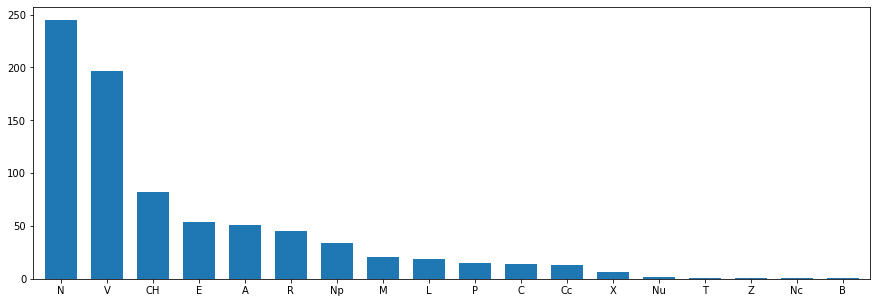

In [34]:
print('Các từ không nằm trong vocabs', end=': ')
for word_tag, word in zip(train_gold, train_words):
    if word == '--unk--': print(word_tag.split()[0], end=', ')
plot_tag_counts(train_gold)

## Tập Test

In [35]:
test_gold = open('dataset/test_gold.txt', encoding='utf-8').readlines()
print('Số lượng từ trong tập test_gold:', len(test_gold))
test_gold[0:5]

Số lượng từ trong tập test_gold: 116


['Những\tL\n', 'ngày\tN\n', 'đẹp_đẽ\tA\n', 'ấy\tP\n', ',\tCH\n']

In [36]:
test_words = preprocess(vocabs_dict, 'dataset/test_words.txt')
print('Số lượng từ trong tập test_words:', len(test_words))
test_words[0:5]

Số lượng từ trong tập test_words: 116


['Những', 'ngày', 'đẹp_đẽ', 'ấy', ',']

Các từ không nằm trong vocabs: Giáng_sinh, năm_qua, gần_đây, Tân_Sơn_Nhất, 

,N,V,P,CH,A,R,E,L,X,Np,Cc,M,Total
0,31,15,12,12,11,8,7,3,3,2,2,1,107


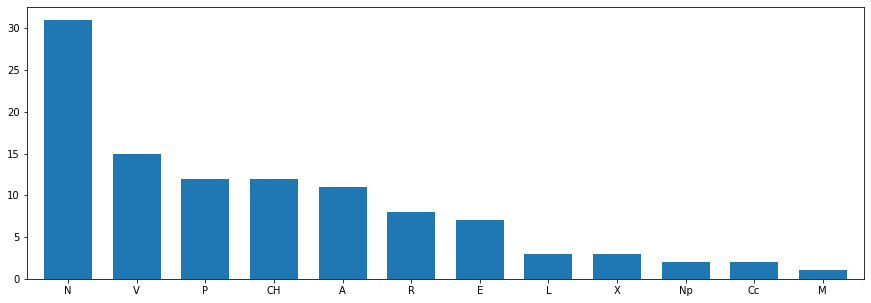

In [37]:
print('Các từ không nằm trong vocabs', end=': ')
for word_tag, word in zip(test_gold, test_words):
    if word == '--unk--': print(word_tag.split()[0], end=', ')
plot_tag_counts(test_gold)

# 5. Parts of Speech Tagging

## Training

In [38]:
def seperate_word_tag(word_tag, vocabs_dict): 
    if not word_tag.split():
        word = '--n--'
        tag = '--s--'
    else:
        word, tag = word_tag.split()
        if word not in vocabs_dict: word = '--unk--'
    return word, tag

In [39]:
def create_dictionaries(train_gold, vocab):
    emission_counts = defaultdict(int)
    transition_counts = defaultdict(int)
    tag_counts = defaultdict(int)
    
    prev_tag = '--s--' 
    for word_tag in train_gold:
        word, tag = seperate_word_tag(word_tag, vocab) 
        
        transition_counts[(prev_tag, tag)] += 1
        emission_counts[(tag, word)] += 1
        tag_counts[tag] += 1
        prev_tag = tag
    return transition_counts, emission_counts, tag_counts

In [40]:
transition_counts, emission_counts, tag_counts = create_dictionaries(train_gold, vocabs_dict)
states = sorted(tag_counts.keys())
print('Số nhãn:', len(states))
print(states)

Số nhãn: 19
['--s--', 'A', 'B', 'C', 'CH', 'Cc', 'E', 'L', 'M', 'N', 'Nc', 'Np', 'Nu', 'P', 'R', 'T', 'V', 'X', 'Z']


In [41]:
print("Transition examples: ")
for example in list(transition_counts.items())[:3]:
    print(example)

Transition examples: 
(('--s--', 'N'), 28)
(('N', 'V'), 68)
(('V', 'E'), 21)


In [42]:
print("Emission examples: ")
for example in list(emission_counts.items())[:3]:
    print (example)

Emission examples: 
(('N', 'Pha'), 1)
(('V', 'lập_công'), 1)
(('E', 'trên'), 4)


## Testing

In [43]:
def predict_pos(words, gold, emission_counts, vocabs_dict, states):
    num_correct = 0
    all_words = set(emission_counts.keys())
    
    for word, gold_tuple in zip(words, gold): 
        gold_tuple_list = gold_tuple.split()
        if len(gold_tuple_list) != 2: continue
        else: true_label = gold_tuple_list[1]
    
        count_final = 0
        pos_final = ''
        if word not in vocabs_dict: continue
        
        for pos in states:
            if (pos, word) not in emission_counts: continue
            count = emission_counts[(pos, word)]
            
            if count > count_final:
                count_final = count
                pos_final = pos
                    
        if pos_final == true_label: num_correct += 1
    accuracy = num_correct / len(gold)
    return accuracy

In [44]:
accuracy = predict_pos(train_words, train_gold, emission_counts, vocabs_dict, states)
print('Độ chính xác trên tập train:', accuracy)

Độ chính xác trên tập train: 0.9341950646298472


In [45]:
accuracy = predict_pos(test_words, test_gold, emission_counts, vocabs_dict, states)
print('Độ chính xác trên tập test:', accuracy)

Độ chính xác trên tập test: 0.4224137931034483


# 6. Ma trận xác suất Hidden Markov

## Ma trận chuyển tiếp 'A' (transition matrix)

In [46]:
def create_transition_matrix(alpha, tag_counts, transition_counts):
    all_tags = sorted(tag_counts.keys())
    num_tags = len(all_tags)
    
    A = np.zeros((num_tags, num_tags))
    trans_keys = set(transition_counts.keys())
    
    for i in range(num_tags):
        for j in range(num_tags):
            count = 0
            key = (all_tags[i], all_tags[j])
            if key in transition_counts: count = transition_counts[key]
                
            count_prev_tag = tag_counts[all_tags[i]]
            A[i, j] = (count + alpha) / (count_prev_tag + alpha * num_tags)
    return A

In [47]:
alpha = 0.001
for i in range(len(states)): tag_counts.pop(i, None)
    
A = create_transition_matrix(alpha, tag_counts, transition_counts)
df = pd.DataFrame(
    A[5:10, 5:10], 
    index = states[5:10], 
    columns = states[5:10]
)
df.head()

,Cc,E,L,M,N
Cc,0.000077,0.000077,0.076888,0.076888,0.230509
E,0.018531,0.000019,0.092579,0.055555,0.536867
L,0.000053,0.000053,0.000053,0.000053,0.999054
M,0.047624,0.047624,0.000048,0.142776,0.523384
N,0.016329,0.077549,0.000004,0.020411,0.232639


## Ma trận phát xạ 'B' (emission matrix)

In [48]:
def create_emission_matrix(alpha, tag_counts, emission_counts, vocabs):
    all_tags = sorted(tag_counts.keys())
    num_tags = len(tag_counts)
    num_words = len(vocabs)
    
    B = np.zeros((num_tags, num_words))
    emis_keys = set(list(emission_counts.keys()))
    
    for i in range(num_tags):
        for j in range(num_words):
            count = 0
            key = (all_tags[i], vocabs[j])
            if key in emission_counts.keys(): count = emission_counts[key]
                
            count_tag = tag_counts[all_tags[i]]
            B[i, j] = (count + alpha) / (count_tag + alpha * num_words)
    return B

In [49]:
cidx  = ['thông_báo', 'hạt_nhân', 'tinh_thần', 'lập_công', 'vị_trí']
rvals = ['N', 'V', 'CH', 'Cc', 'E', 'L']
cols = [vocabs_dict[word] for word in cidx]
rows = [states.index(tag) for tag in rvals]

for i in range(len(states)): tag_counts.pop(i, None)
B = create_emission_matrix(alpha, tag_counts, emission_counts, list(vocabs_dict))

df = pd.DataFrame(B[np.ix_(rows, cols)], index=rvals, columns=cidx)
df.head()

,thông_báo,hạt_nhân,tinh_thần,lập_công,vị_trí
N,0.003339,0.006674,0.003339,0.000003,0.010009
V,0.000004,0.000004,0.000004,0.003975,0.000004
CH,0.000007,0.000007,0.000007,0.000007,0.000007
Cc,0.000015,0.000015,0.000015,0.000015,0.000015
E,0.000009,0.000009,0.000009,0.000009,0.000009


# 7. Thuật toán Viterbi

## Bước Initialization

In [50]:
def viterbi_initialize(states, tag_counts, A, B, corpus, vocabs_dict):
    num_tags = len(tag_counts)
    s_idx = states.index('--s--')
    
    best_probs = np.zeros((num_tags, len(corpus)))
    best_paths = np.zeros((num_tags, len(corpus)), dtype=int)
    
    for i in range(num_tags):
        if A[s_idx, i] == 0: best_probs[i, 0] = float('-inf')
        else: 
            index = vocabs_dict[corpus[0]]
            best_probs[i, 0] = math.log(A[s_idx, i]) + math.log(B[i, index])
    return best_probs, best_paths

In [51]:
best_probs_train, best_paths_train = viterbi_initialize(states, tag_counts, A, B, train_words, vocabs_dict)
print('best_probs_train[0, 0]:', best_probs_train[0, 0]) 
print('best_paths_train[2, 3]:', best_paths_train[2, 3])

best_probs_train[0, 0]: -22.350357902121928
best_paths_train[2, 3]: 0


In [52]:
best_probs_test, best_paths_test = viterbi_initialize(states, tag_counts, A, B, test_words, vocabs_dict)
print('best_probs_test[0, 0]:', best_probs_test[0, 0]) 
print('best_paths_test[2, 3]:', best_paths_test[2, 3])

best_probs_test[0, 0]: -22.350357902121928
best_paths_test[2, 3]: 0


## Bước Forward

In [53]:
def viterbi_forward(A, B, corpus, best_probs, best_paths, vocabs_dict):
    num_tags = best_probs.shape[0]
    
    for i in range(1, len(corpus)): 
        if i % 5000 == 0: print(f'Processed {i} words...')
            
        for j in range(num_tags):
            best_prob_i = float('-inf')
            best_path_i = None
            
            for k in range(num_tags):
                index = vocabs_dict[corpus[i]]
                prob = best_probs[k, i - 1] + math.log(A[k, j]) + math.log(B[j, index])

                if prob > best_prob_i:
                    best_prob_i = prob
                    best_path_i = k
                    
            best_probs[j, i] = best_prob_i
            best_paths[j, i] = best_path_i
            
    return best_probs, best_paths

In [54]:
best_probs_train, best_paths_train = viterbi_forward(A, B, train_words, best_probs_train, best_paths_train, vocabs_dict)
print('best_probs_train[0, 1]:', best_probs_train[0, 1]) 
print('best_paths_train[0, 4]:', best_paths_train[0, 4])

best_probs_train[0, 1]: -30.221629560416723
best_paths_train[0, 4]: 4


In [55]:
best_probs_test, best_paths_test = viterbi_forward(A, B, test_words, best_probs_test, best_paths_test, vocabs_dict)
print('best_probs_test[0, 1]:', best_probs_test[0, 1]) 
print('best_paths_test[0, 4]:', best_paths_test[0, 4])

best_probs_test[0, 1]: -27.986761593157688
best_paths_test[0, 4]: 4


## Bước Backward

In [56]:
def viterbi_backward(best_probs, best_paths, corpus, states):
    m = best_paths.shape[1] 
    z = [None] * m
    
    num_tags = best_probs.shape[0]
    best_prob_for_last_word = float('-inf')
    pred = [None] * m
    
    for k in range(num_tags):
        if best_probs[k, m - 1] > best_prob_for_last_word:
            best_prob_for_last_word = best_probs[k, m - 1]
            z[m - 1] = k
            
    pred[m - 1] = states[z[m - 1]]
    for i in range(m - 1, -1, -1):
        z[i - 1] = best_paths[z[i], i]
        pred[i - 1] = states[z[i - 1]]
    return pred

In [57]:
train_pred = viterbi_backward(best_probs_train, best_paths_train, train_words, states)
test_pred = viterbi_backward(best_probs_test, best_paths_test, test_words, states)
m = len(test_pred)

print(f'Dự đoán cho test_pred[-7:{m - 1}]:')
print(test_words[-7:m-1])
print(test_pred[-7:m-1])

print('Dự đoán cho test_pred[0:7]:')
print(test_words[0:7])
print(test_pred[0:7])

Dự đoán cho test_pred[-7:115]:
['là', 'công_cụ', 'không_thể', 'đảo_ngược', 'trong', 'cuộc_sống']
['V', 'Np', 'R', 'V', 'E', 'N']
Dự đoán cho test_pred[0:7]:
['Những', 'ngày', 'đẹp_đẽ', 'ấy', ',', 'bố', 'luôn']
['L', 'N', 'Cc', 'A', 'CH', 'P', 'R']


# 8. Đánh giá kết quả

## Kết quả của mô hình Hidden Markov kết hợp thuật toán Viterbi

In [58]:
for word, tag in zip(test_words, test_pred):
    if word == '--n--': print()
    else: print(f'{word}/{tag}', end=' ')

Những/L ngày/N đẹp_đẽ/Cc ấy/A ,/CH bố/P luôn/R dành/V thời_gian/N để/E vui_vẻ/N với/E anh_em/N tôi/P ./CH 
Trong/E khi/N chờ/E nước/N nóng/A ,/CH tôi/P pha/V rượu/N táo/Cc nóng/A ./CH 
Hàng/C trăm/M người/N đến/V dùng/E tiệc/M tự_chọn/Nu ở/E chỗ/CH mẹ/--s-- những/L ngày/N --unk--/A ./CH 
Năm/P nào/R cũng/R vậy/A hoặc/Cc có_vẻ/A như_vậy/A ./CH 
Tôi/P chưa/CH bao_giờ/--s-- thực_sự/L cảm_thấy/N mệt_mỏi/CH vì/--s-- nó/P ./CH 
Tôi/P đã/R có_thể/R chống/V lại/E cảm_giác/N đó/V trong/E nhiều/A --unk--/A ./CH 
Những/L năm/N --unk--/CH tôi/P qua_lại/CH sân_bay/--s-- --unk--/L thường_xuyên/N ./CH 
Trường/N tôi/P từng/R nghiêm_cấm/V sử_dụng/V điện_thoại/V trong/E lớp/N ./CH 
Học_sinh/P ngày_nay/R có_thể/R dễ_dàng/A tiếp_cận/Cc bài_học/A và/Cc phương_pháp/A giải/Cc bài_tập/A ./CH 
Điện_thoại/P thông_minh/R là/V công_cụ/Np không_thể/R đảo_ngược/V trong/E cuộc_sống/N ./--s-- 

In [59]:
from sklearn.metrics import classification_report
def report(pred, gold):
    y_pred = []
    y_true = []

    for prediction, word_tag in zip(pred, gold):
        word_tag_tuple = word_tag.split()
        if len(word_tag_tuple) != 2: continue 

        word, tag = word_tag_tuple
        y_pred.append(prediction)
        y_true.append(tag)

    print(classification_report(y_pred, y_true))
    return y_pred, y_true

In [60]:
print('Kết quả của mô hình Hidden Markov kết hợp thuật toán Viterbi trên tập train:\n')
y_pred, y_true_train = report(train_pred, train_gold)

Kết quả của mô hình Hidden Markov kết hợp thuật toán Viterbi trên tập train:

              precision    recall  f1-score   support

       --s--       0.00      0.00      0.00         1
           A       1.00      1.00      1.00        51
           B       1.00      1.00      1.00         1
           C       0.93      0.93      0.93        14
          CH       0.99      1.00      0.99        81
          Cc       1.00      1.00      1.00        13
           E       0.91      0.96      0.93        51
           L       1.00      1.00      1.00        19
           M       1.00      1.00      1.00        21
           N       1.00      0.99      1.00       247
          Nc       1.00      1.00      1.00         1
          Np       1.00      1.00      1.00        34
          Nu       1.00      1.00      1.00         2
           P       1.00      1.00      1.00        15
           R       1.00      0.98      0.99        46
           T       1.00      1.00      1.00         1
   

In [61]:
print('Kết quả của mô hình Hidden Markov kết hợp thuật toán Viterbi trên tập test:\n')
y_pred, y_true_test = report(test_pred, test_gold)

Kết quả của mô hình Hidden Markov kết hợp thuật toán Viterbi trên tập test:

              precision    recall  f1-score   support

       --s--       0.00      0.00      0.00         5
           A       0.36      0.31      0.33        13
           C       0.00      0.00      0.00         1
          CH       0.92      0.69      0.79        16
          Cc       1.00      0.33      0.50         6
           E       0.86      0.60      0.71        10
           L       1.00      0.60      0.75         5
           M       1.00      0.50      0.67         2
           N       0.42      0.81      0.55        16
          Np       0.00      0.00      0.00         1
          Nu       0.00      0.00      0.00         1
           P       0.58      0.64      0.61        11
           R       0.75      0.60      0.67        10
           V       0.53      0.80      0.64        10
           X       0.00      0.00      0.00         0

    accuracy                           0.57       107
   

## Kết quả khi sử dụng thư viện VnCoreNLP

In [62]:
def predict_by_lib(gold, print_results=False):
    y_pred_lib = []

    for word_tag in gold:
        word_tag_tuple = word_tag.split()
        if len(word_tag_tuple) != 2: 
            if print_results: print()
            continue 

        word, tag = word_tag_tuple
        if '_' not in word: pred = client.pos_tag(word)
        else: pred = client.pos_tag(word.replace('_', ' '))

        if print_results: print(f'{word}/{pred[0][0][1]}', end=' ') 
        y_pred_lib.append(pred[0][0][1])
    return y_pred_lib

In [63]:
y_pred_lib_train = predict_by_lib(train_gold)
y_pred_lib_test = predict_by_lib(test_gold, True)

Những/L ngày/N đẹp_đẽ/A ấy/P ,/CH bố/N luôn/R dành/V thời_gian/N để/E vui_vẻ/A với/E anh_em/N tôi/P ./CH 
Trong/E khi/N chờ/V nước/N nóng/A ,/CH tôi/P pha/V rượu/N táo/V nóng/A ./CH 
Hàng/N trăm/M người/N đến/V dùng/V tiệc/N tự_chọn/P ở/E chỗ/N mẹ/N những/L ngày/N Giáng_sinh/Np ./CH 
Năm/Np nào/P cũng/R vậy/P hoặc/Cc có_vẻ/X như_vậy/X ./CH 
Tôi/P chưa/R bao_giờ/P thực_sự/A cảm_thấy/V mệt_mỏi/A vì/E nó/P ./CH 
Tôi/P đã/R có_thể/R chống/V lại/R cảm_giác/N đó/P trong/E nhiều/A năm_qua/N ./CH 
Những/L năm/N gần_đây/A tôi/P qua_lại/V sân_bay/N Tân_Sơn_Nhất/Np thường_xuyên/A ./CH 
Trường/Np tôi/P từng/P nghiêm_cấm/V sử_dụng/V điện_thoại/N trong/E lớp/N ./CH 
Học_sinh/N ngày_nay/N có_thể/R dễ_dàng/A tiếp_cận/V bài_học/N và/Cc phương_pháp/N giải/N bài_tập/N ./CH 
Điện_thoại/N thông_minh/A là/V công_cụ/N không_thể/R đảo_ngược/V trong/E cuộc_sống/N ./CH 

In [64]:
print('Kết quả khi sử dụng thư viện VnCoreNLP trên tập train:\n')
print(classification_report(y_pred_lib_train, y_true_train))

Kết quả khi sử dụng thư viện VnCoreNLP trên tập train:

              precision    recall  f1-score   support

           A       0.94      0.98      0.96        49
           B       0.00      0.00      0.00         0
           C       0.71      0.91      0.80        11
          CH       1.00      1.00      1.00        82
          Cc       1.00      1.00      1.00        13
           E       1.00      0.86      0.92        63
           L       0.74      0.93      0.82        15
           M       1.00      0.95      0.98        22
           N       0.89      0.97      0.93       224
          Nc       1.00      1.00      1.00         1
          Np       0.88      0.58      0.70        52
          Nu       1.00      1.00      1.00         2
           P       1.00      1.00      1.00        15
           R       0.98      0.98      0.98        45
           T       1.00      1.00      1.00         1
           V       0.97      0.96      0.96       201
           X       0.83  

In [65]:
print('Kết quả khi sử dụng thư viện VnCoreNLP trên tập test:\n')
print(classification_report(y_pred_lib_test, y_true_test))

Kết quả khi sử dụng thư viện VnCoreNLP trên tập test:

              precision    recall  f1-score   support

           A       0.91      0.91      0.91        11
          CH       1.00      1.00      1.00        12
          Cc       1.00      1.00      1.00         2
           E       1.00      0.88      0.93         8
           L       1.00      1.00      1.00         3
           M       1.00      1.00      1.00         1
           N       0.87      0.96      0.92        28
          Np       1.00      0.50      0.67         4
           P       1.00      0.86      0.92        14
           R       0.88      0.88      0.88         8
           V       0.87      0.93      0.90        14
           X       0.67      1.00      0.80         2

    accuracy                           0.92       107
   macro avg       0.93      0.91      0.91       107
weighted avg       0.92      0.92      0.91       107

